In [1]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import warnings

pd.set_option('display.max_columns', None)

import sys 
sys.path.append(r'..\utils') 
from utils import get_seaad_colors, get_tx_order


c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Choose seaad mapping alg

In [2]:
#HANN mapping
class_col = 'class_label_Hierarchical'
subclass_col = 'subclass_label_Hierarchical'
cluster_col = 'cluster_label_Hierarchical'

### Data wrangling

In [3]:
# old_data = pd.read_csv(r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\ephys\20250812\20250812_ephys_features_imputed.csv')
# new_data = pd.read_csv(r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\ephys\20251008\20251008_ephys_features_imputed.csv')


In [4]:
include_depth = True

In [5]:
#Load data
metadata_path = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\metadata\20251008\Datalock_Human_Glut_4_4_25(patchseq_mapping_results).csv'
ephys_data_path = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\ephys\20251008\20251008_ephys_features_imputed.csv'

out_dir = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\analysis\20251010_seaad\E_UMAP'
os.makedirs(out_dir, exist_ok=True)

metadata = pd.read_csv(metadata_path, encoding='latin1')
features = pd.read_csv(ephys_data_path)

#identify ttype and feature columns
if include_depth: 
    feature_columns = features.columns[5:] 
    depth_tag = 'withDepth'
else:
    feature_columns = features.columns[6:] 
    depth_tag = 'withoutDepth'

ttype_columns = [class_col, subclass_col, cluster_col]

#combine data
metadata = metadata.rename(columns={'cell_id' : 'specimen_id'})
cells = metadata[['specimen_id', class_col, cluster_col]].merge(features, how='inner', on='specimen_id')
cells = cells.rename(columns={'depth_from_pia_norm_y' : 'depth_from_pia_norm'})

#get SEAAD colors
color_dict = get_seaad_colors()

#get custom transcriptomic order
ttype_order, subclass_order = get_tx_order()
group_order = {
    'subclass_label' : subclass_order,
    't_type' :  ttype_order
}


In [6]:
[c for c in feature_columns if 'dist' in c.lower() or 'depth' in c.lower()]

['depth_from_pia_norm']

In [7]:
len(features) == len(cells)

True

### PCA

In [8]:
cells_input = cells[feature_columns] #input for pca - just morpho features 

#scale data for PCA 
scaler = StandardScaler()
scaler.fit(cells_input)
scaled_data = scaler.transform(cells_input)

In [9]:
cells_input

,depth_from_pia_norm,combined_upstroke_downstroke_ratio_rheo,combined_width_rheo,combined_upstroke_rheo,combined_downstroke_rheo,combined_sag,combined_baseline,combined_input_resistance_SS,combined_tau,combined_peak_v,combined_trough_v_rheo,combined_fast_trough_v_rheo,combined_peak_freq_chirp,combined_peak_impedance_chirp,combined_AP_threshold,sm_rheobase_i,sm_fi_fit_slope,sm_latency_rheo,sm_avg_rate_hero,sm_mean_isi_hero,sm_isi_adapt_ratio,sm_trough_slowdeltav_hero,sm_fast_trough_deltav_hero,sm_adapt_mean
0,0.078947,3.211802,0.00082,334.069783,-104.013178,0.055736,-80.312561,112.312919,0.021487,43.593754,-57.343750,-51.531250,1.142256,30.330046,-42.093754,110.000000,0.073350,0.516160,2.000000,0.424060,1.727077,-3.687500,-6.750000,0.084234
1,0.083616,3.454465,0.00090,340.816348,-98.659674,0.013199,-60.440277,195.783615,0.033725,42.093754,-53.500004,-52.843754,1.112923,41.361118,-43.218750,40.000000,0.184615,0.186180,13.000000,0.075002,1.461892,-0.343754,-6.468750,0.041872
2,0.092861,2.494339,0.00076,295.422382,-118.437141,0.088310,-61.148098,266.392316,0.036280,37.375004,-57.156254,-54.281254,1.065745,52.335991,-44.875004,29.999998,0.170833,0.168780,14.000000,0.069825,1.284653,-0.250000,-5.687500,0.019248
3,0.182819,2.820922,0.00088,288.994739,-102.446913,0.025727,-79.178276,195.932576,0.032700,34.156250,-60.937500,-58.343754,1.080389,48.659918,-47.687500,70.000000,0.141354,0.178740,8.000000,0.113129,1.365858,-0.281250,-9.562500,0.028038
4,0.189629,2.857546,0.00082,315.960019,-110.570396,0.028507,-69.816376,165.995021,0.029542,47.312500,-50.500000,-47.156254,1.135470,44.673717,-40.062504,59.999996,0.096665,0.157160,6.000000,0.164280,1.493380,-0.156250,-6.156250,0.084064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,0.895380,4.272546,0.00114,354.628488,-83.001684,0.189482,-59.572395,75.460184,0.018309,48.343750,-54.750004,-54.187504,1.583297,43.227571,-42.500000,90.000000,0.120938,0.076920,8.000000,0.120951,1.420296,-0.062496,-11.093750,0.067566
956,0.698041,3.924382,0.00154,227.736341,-58.031140,0.122349,-71.325699,149.885557,0.033285,23.937502,-57.875004,-57.343750,1.583297,43.227571,-48.437504,90.000000,0.100371,0.141320,8.000000,0.127817,1.531302,-0.375004,-11.031246,0.089471
957,0.633789,6.509346,0.00142,366.106188,-56.243163,0.131467,-68.745613,126.410366,0.047325,50.156250,-53.343754,-49.812504,1.583297,43.227571,-41.875000,100.000000,0.082037,0.196720,7.000000,0.130517,1.746893,-1.156246,-8.593754,0.056813
958,0.641675,4.980417,0.00110,378.358256,-75.969195,0.104338,-61.352932,60.441263,0.023947,49.649998,-50.368748,-50.274998,2.150641,71.597614,-39.099998,110.888889,0.106580,0.172066,7.444444,0.119095,3.672775,-0.697918,-14.017360,0.072382


In [10]:
#PCA with num components that explain 95% variance. 

pca95 = PCA(n_components=0.95, svd_solver='full')
x_pca95 = pca95.fit_transform(scaled_data)

#make pca df for visuals
x_pca95_df = pd.concat([cells[['specimen_id', class_col, subclass_col, cluster_col]], pd.DataFrame(x_pca95)], axis=1)

x_pca95.shape


(960, 16)

Text(0, 0.5, 'PCA 2')

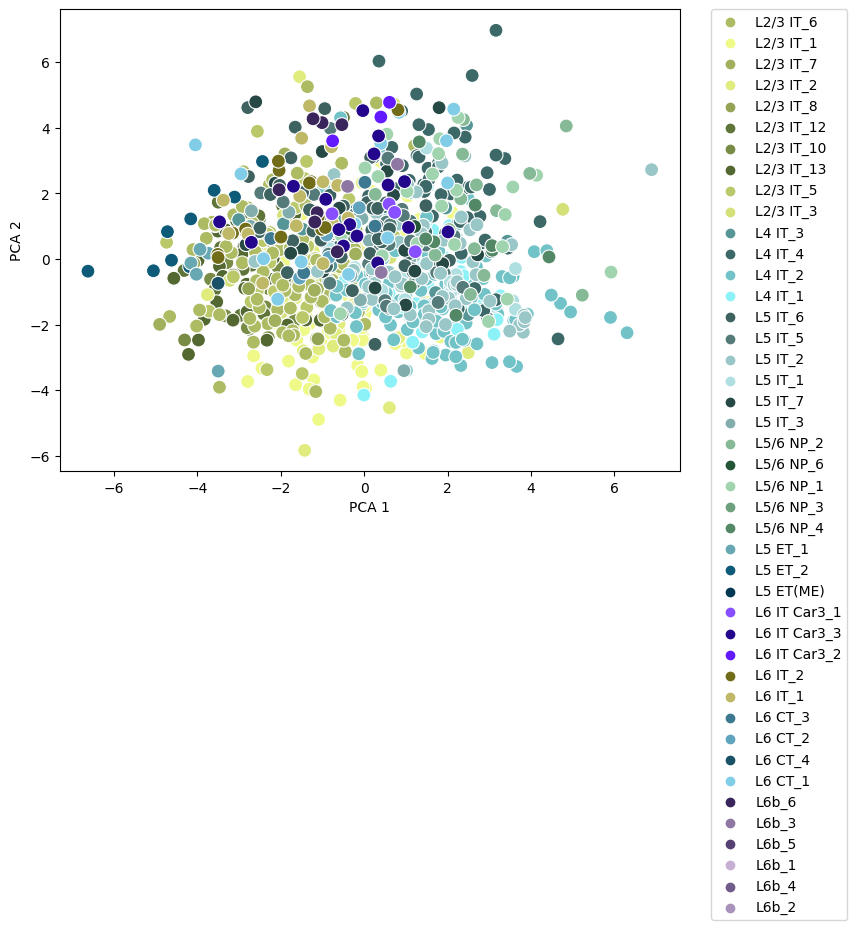

In [11]:
#show PCA 1 and 2 colored by ttype 
plt.figure(figsize=(8,6))
sns.scatterplot(data=x_pca95_df, x=0, y=1, hue=cluster_col, hue_order = group_order['t_type'], palette=color_dict, s=100)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')


In [12]:
#save PCA data
x_pca95_df = pd.DataFrame(x_pca95)
x_pca95_df['specimen_id'] = cells.specimen_id
x_pca95_df = x_pca95_df.set_index('specimen_id')
x_pca95_df.to_csv(os.path.join(out_dir, f'human_excitatory_pca_95_ephys_features_{depth_tag}.csv'))


### UMAP from PCA

Parameter fitting

In [13]:
# #UMAP - testing num neighbors 
# nns = [13, 15, 17, 20, 22, 25] #num neighbors 
# md = 0.1 #min dist 

# fig_path = os.path.join(out_dir, 'human_excitatory_pca95_umap_ephys_features_nNeighborsTesting_minDist{}.pdf'.format(str(md).replace('.', '-')))

# with PdfPages(fig_path) as pdf:
#   with warnings.catch_warnings():
#     warnings.simplefilter(action='ignore', category=FutureWarning)

#   for nn in nns:
#     #2d umap from pca
#     umap_2d = UMAP(n_components=2, n_neighbors=nn, min_dist=md, metric='euclidean', init='random', random_state=0)
#     proj_2d = umap_2d.fit_transform(x_pca95_df)
#     proj_2d_df = pd.concat([cells[['specimen_id', class_col, subclass_col, cluster_col]], pd.DataFrame(proj_2d)], axis=1)

#     fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(6,6)) #,sharey=True, figsize=(20,10)) 

#     #plot
#     # plt.scatter(proj_2d[:,0], proj_2d[:,1], c=ttype_color)
#     sns.scatterplot(data=proj_2d_df, x=0, y=1, hue=cluster_col, hue_order=group_order['t_type'], palette=seaad_color_dict, s=100)
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
#     plt.xlabel('UMAP 1')
#     plt.ylabel('UMAP 2')
#     plt.title('n_neighbors {}, min_dist {}'.format(nn, md))

#     #save fig
#     pdf.savefig(fig, bbox_inches='tight')
#     plt.show() #show the fig
#     plt.clf() #destoy current fig to save memory


In [14]:
# #UMAP - testing min distance
# nn = 15 #num neighbors 
# mds = [0.0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.8, 0.99] #min dist 

# fig_path = os.path.join(out_dir, 'human_excitatory_pca95_umap_ephys_features_nNeighbors{}_minDistTesting.pdf'.format(str(nn).replace('.', '-')))

# with PdfPages(fig_path) as pdf:
#   with warnings.catch_warnings():
#     warnings.simplefilter(action='ignore', category=FutureWarning)

#   for md in mds:
#     #2d umap from pca
#     umap_2d = UMAP(n_components=2, n_neighbors=nn, min_dist=md, metric='euclidean', init='random', random_state=0)
#     proj_2d = umap_2d.fit_transform(x_pca95_df)
#     proj_2d_df = pd.concat([cells[['specimen_id', class_col, subclass_col, cluster_col]], pd.DataFrame(proj_2d)], axis=1)

#     fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(6,6)) #,sharey=True, figsize=(20,10)) 

#     #plot
#     # plt.scatter(proj_2d[:,0], proj_2d[:,1], c=ttype_color)
#     sns.scatterplot(data=proj_2d_df, x=0, y=1, hue=cluster_col, hue_order=group_order['t_type'], palette=seaad_color_dict, s=100)
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
#     plt.xlabel('UMAP 1')
#     plt.ylabel('UMAP 2')
#     plt.title('n_neighbors {}, min_dist {}'.format(nn, md))

#     #save fig
#     pdf.savefig(fig, bbox_inches='tight')
#     plt.show() #show the fig
#     plt.clf() #destoy current fig to save memory


UMAP with best params

In [15]:
NN = 15
MD = 0.1

c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v3\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


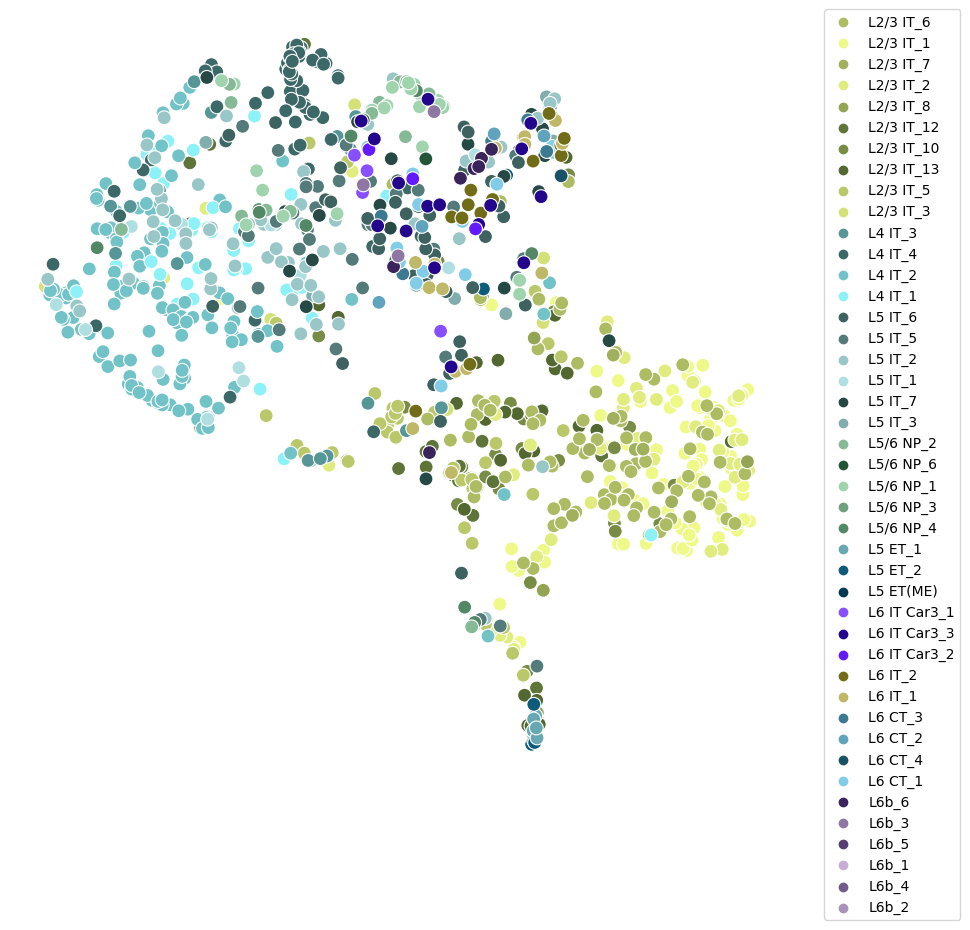

<Figure size 640x480 with 0 Axes>

In [16]:
#UMAP - best combo 
nn = NN
md = MD

fig_path = os.path.join(out_dir, 'human_excitatory_pca95_umap_ephys_features_nNeighbors{}_minDist{}_colorTreeCluster_{}.pdf'.format(nn, str(md).replace('.', '-'), depth_tag))


with PdfPages(fig_path) as pdf:
  with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

  #compute umap
  umap_2d = UMAP(n_components=2, n_neighbors=nn, min_dist=md, metric='euclidean', init='random', random_state=0)
  proj_2d = umap_2d.fit_transform(x_pca95_df)
  proj_2d_df = pd.concat([cells[['specimen_id', class_col, subclass_col, cluster_col]], pd.DataFrame(proj_2d)], axis=1)

  fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10,10)) #,sharey=True, figsize=(20,10)) 
  ax.axis('off')

  #plot
  sns.scatterplot(data=proj_2d_df, x=0, y=1, hue=cluster_col, hue_order=group_order['t_type'], palette=color_dict, s=100)

  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
  plt.xlabel('UMAP 1')
  plt.ylabel('UMAP 2')

  #save fig
  pdf.savefig(fig, bbox_inches='tight')
  plt.show() #show the fig
  plt.clf() #destoy current fig to save memory


In [17]:
# umap into df
umap_df = pd.DataFrame(proj_2d, columns=['umap_1', 'umap_2'])
umap_df['specimen_id'] = cells['specimen_id'].values.tolist()
umap_df = umap_df[['specimen_id', 'umap_1', 'umap_2']]
cells = cells.merge(umap_df, how='inner', on='specimen_id')

In [18]:
umap_df.to_csv(os.path.join(out_dir, f'human_excitatory_ephys_umap_2d_nn{NN}_md{MD}_{depth_tag}.csv'), index=False)


##### Color by ttype, subclass, and features

In [19]:
#color vars and corresponding color dicts
color_by = {}
color_by[subclass_col] = color_dict
color_by[cluster_col] = color_dict
color_by['depth_from_pia_norm'] = None
for f in feature_columns: color_by[f] = None


In [20]:
#UMAP

nn = NN
md = MD

fig_path = os.path.join(out_dir, 'human_excitatory_pca95_umap_ephys_features_nNeighbors{}_minDist{}_variousColors_{}.pdf'.format(nn, str(md).replace('.', '-'), depth_tag))

with PdfPages(fig_path) as pdf:
  with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

  #compute umap
  umap_2d = UMAP(n_components=2, n_neighbors=nn, min_dist=md, metric='euclidean', init='random', random_state=0)
  proj_2d = umap_2d.fit_transform(x_pca95_df)

  for color_var, color_var_dict in color_by.items():

    #plot
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(5,5)) 

    if 'SEAAD' in color_var: ax = sns.scatterplot(data=cells.sort_values(by=color_var), x='umap_1', y='umap_2', hue=color_var, palette=color_var_dict)
    else: ax = sns.scatterplot(data=cells, x='umap_1', y='umap_2', hue=color_var, palette=color_var_dict)

    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    for spine in ax.spines.values(): spine.set_visible(False)
    ax.set_xlabel('M UMAP 1')
    ax.set_ylabel('M UMAP 2')
    ax.set_title(color_var)

    #save fig
    pdf.savefig(fig, bbox_inches='tight')
    # plt.show() #show the fig
    plt.clf() #destoy current fig to save memory


c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v3\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\sarah.wallingbell\AppData\Local\Temp\ipykernel_11684\441382438.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(5,5))


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

#### Color subclass ttypes (like ephys plots)

c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v3\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


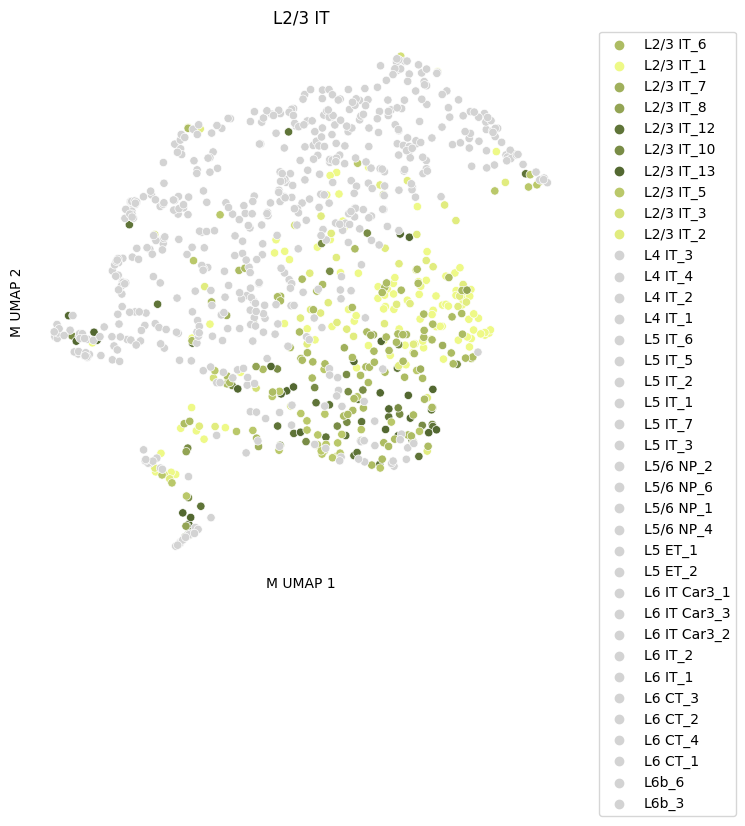

<Figure size 640x480 with 0 Axes>

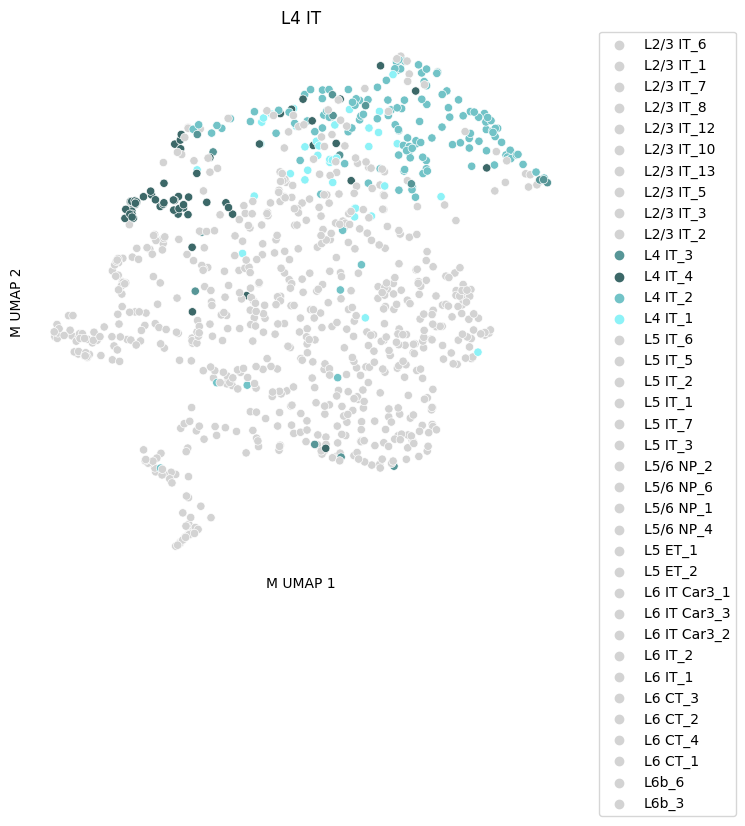

<Figure size 640x480 with 0 Axes>

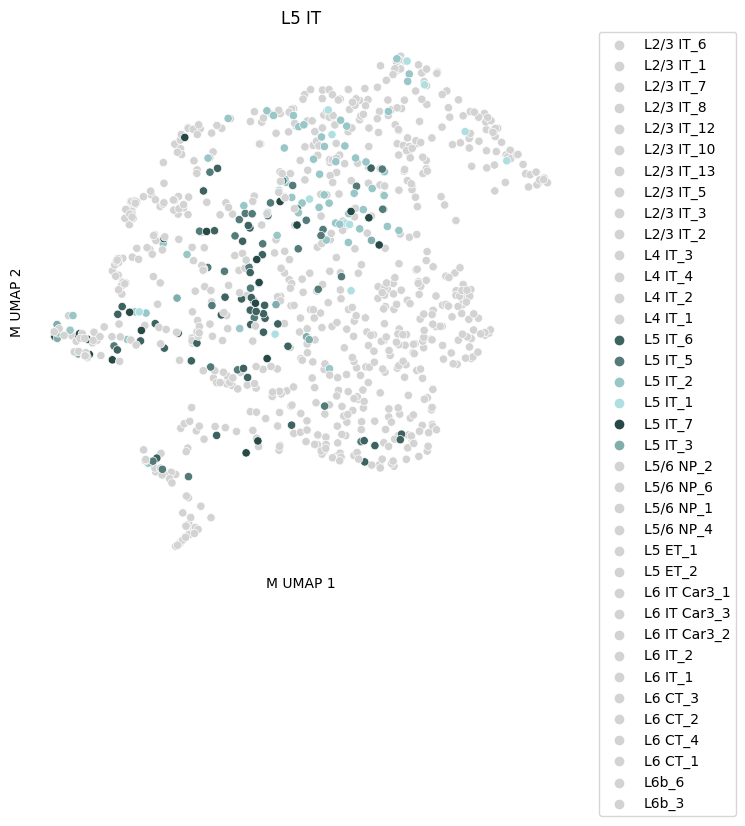

<Figure size 640x480 with 0 Axes>

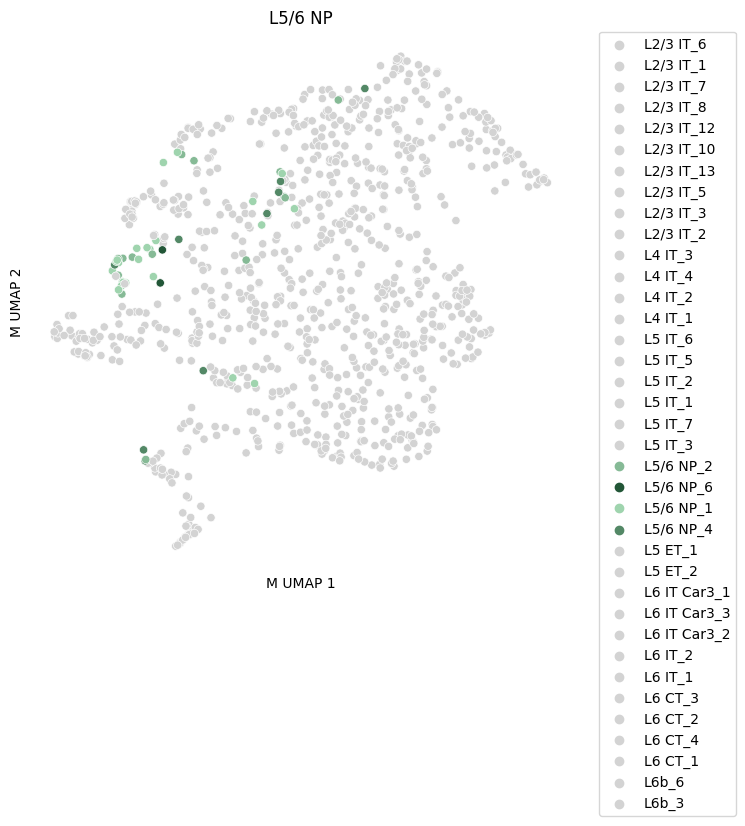

<Figure size 640x480 with 0 Axes>

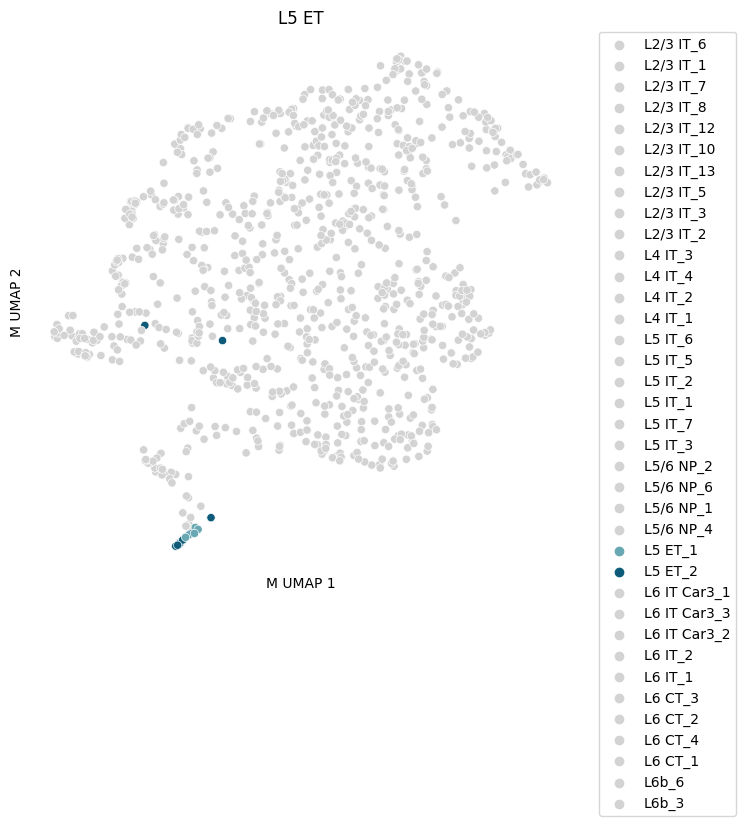

<Figure size 640x480 with 0 Axes>

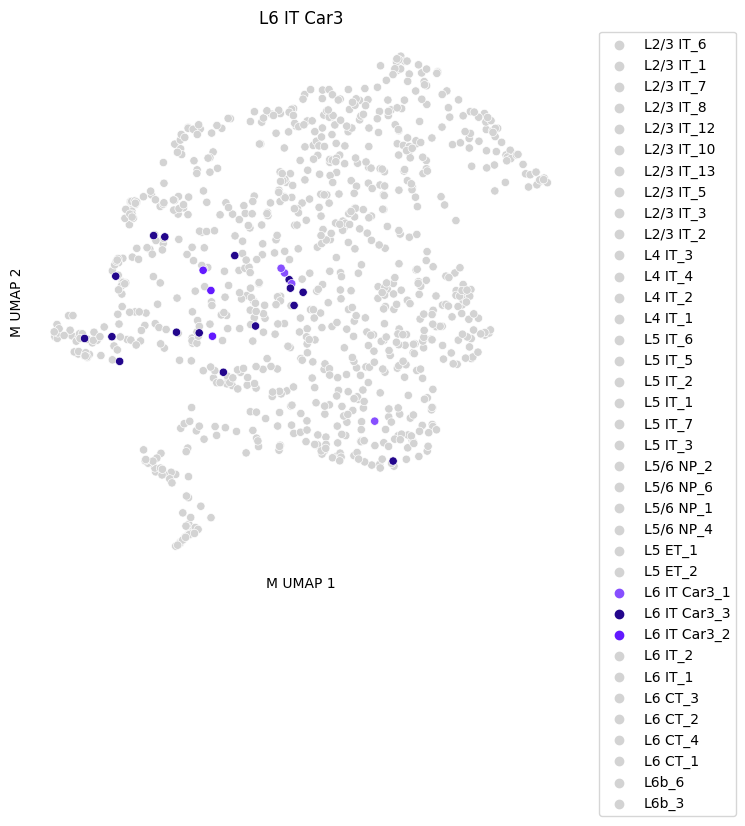

<Figure size 640x480 with 0 Axes>

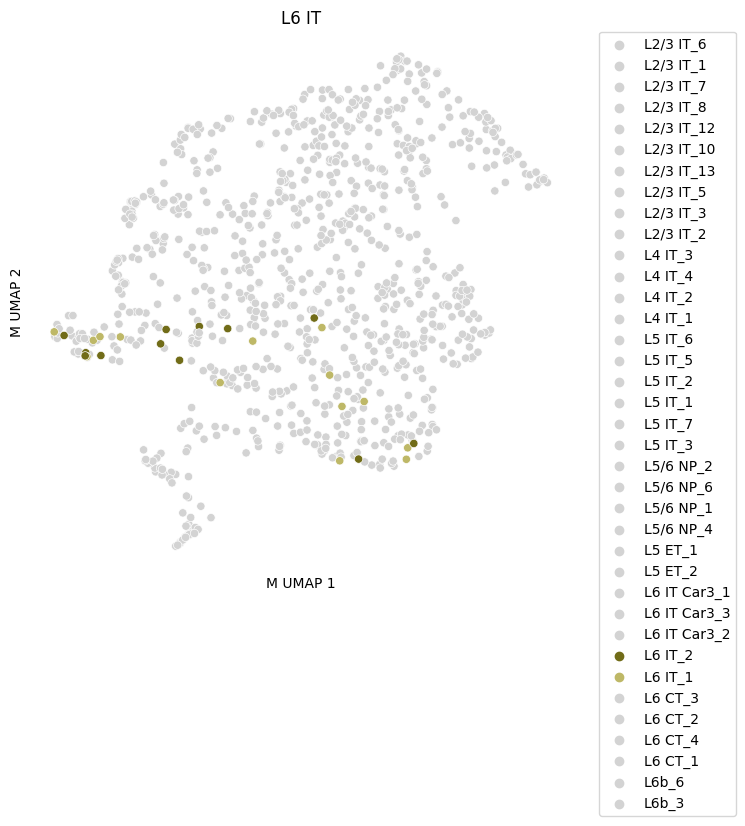

<Figure size 640x480 with 0 Axes>

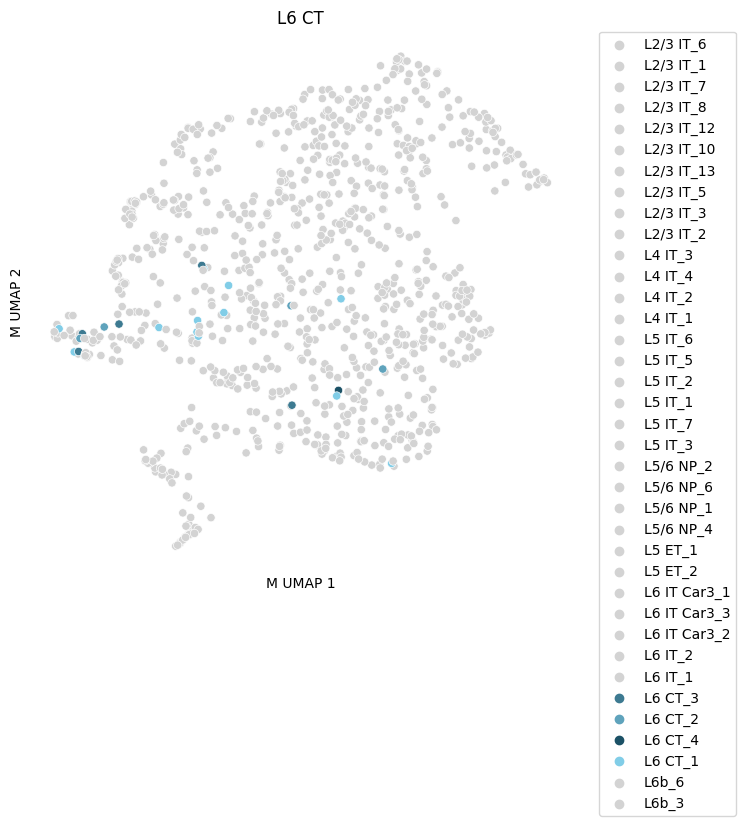

<Figure size 640x480 with 0 Axes>

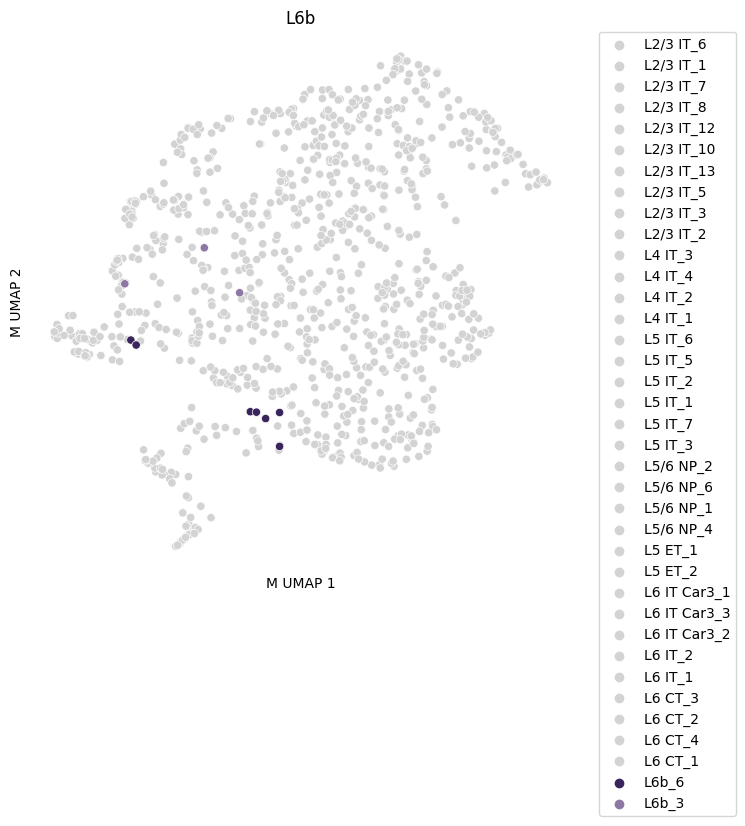

<Figure size 640x480 with 0 Axes>

In [21]:

subclass_ttype_dict = {}
for subclass in group_order['subclass_label']:
    subclass_ttype_dict[subclass] = list(cells[cells[subclass_col] == subclass][cluster_col].unique())

#UMAP

nn = NN
md = MD

fig_path = os.path.join(out_dir, 'human_excitatory_pca95_umap_ephys_features_nNeighbors{}_minDist{}_colorSubclassTtypes_{}.pdf'.format(nn, str(md).replace('.', '-'), depth_tag))

with PdfPages(fig_path) as pdf:
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)

        #compute umap
        umap_2d = UMAP(n_components=2, n_neighbors=nn, min_dist=md, metric='euclidean', init='random', random_state=0)
        proj_2d = umap_2d.fit_transform(x_pca95_df)

        subclasses = list(subclass_ttype_dict.keys())
        for subclass in subclasses:
            
            #create a color dict for this subclass (non subclass ttypes are grey)
            ttypes = subclass_ttype_dict[subclass]
            color_palette = {c:color_dict[c] if c in ttypes else 'lightgrey' for c in cells[cluster_col].unique()}

            #plot
            fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(7,7)) 
            ax = sns.scatterplot(data=cells, x='umap_1', y='umap_2', hue=cluster_col, hue_order=[x for x in ttype_order if x in cells[cluster_col].unique()], palette=color_palette)

            #format
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
            ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
            for spine in ax.spines.values(): spine.set_visible(False)
            ax.set_xlabel('M UMAP 1')
            ax.set_ylabel('M UMAP 2')
            ax.set(title=subclass)

            #save fig
            pdf.savefig(fig, bbox_inches='tight')
            plt.show() #show the fig
            plt.clf() #destoy current fig to save memory


